In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from graphviz import Digraph
import torch


In [2]:
def f(x):
    return 3*x**2 + 4*x + 5

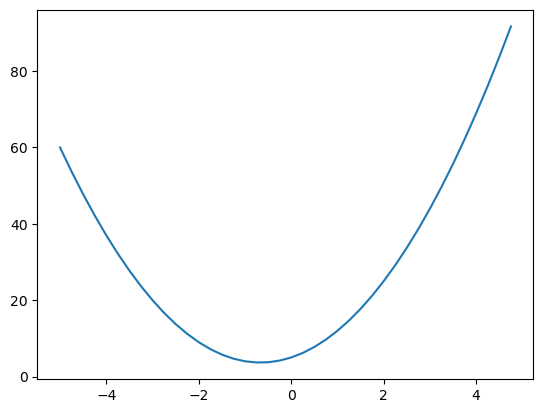

In [3]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
class Value:
    def __init__(self,data, _children: tuple = (), _op = ''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self._backward = lambda: None # Stores how we are going to back-propogate the derivatve
    def __repr__(self):
        return f'Value(data = {self.data}) | Grad(grad = {self.grad})'

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self,other), '+')

        def _backward():
            '''Function to backpropogate the derivative of the loss function'''
            self.grad += 1 * out.grad
            other.grad +=  1 * out.grad 
        out._backward = _backward
        return out

    def __radd__(self,other):
        return self + other
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward 
        return out

    def __rmul__(self,other):
        return self * other

    def __truediv__(self,other):
        return self * other**-1

    def __pow__(self,other):
        assert isinstance(other,(int,float)), 'only supporting int/float powers'
        out = Value(self.data ** other, (self,),f'**{other}')
        def _backward():
            '''Gradient calculation for backpropogation'''
            self.grad += other*(self.data**(other - 1))*out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (other * -1)

    def tanh(self):
        t = (np.exp(2 * self.data) - 1) / (np.exp(2 * self.data) + 1)
        out =  Value(t,(self,),'tanh')

        def _backward():
            self.grad += (1 - t**2)*out.grad 
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    def backward(self):
        
        topo = []
        visited = set()
        def buildtopo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    buildtopo(child)
                topo.append(v)
        buildtopo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

        

In [5]:
a = Value(2.0) 
b = Value(4.0)
# c = Value(10.0)
# e = a*b
# d = e + c
# f = Value(-2.0)
# L = d*f
# print(L)
a-b

Value(data = -2.0) | Grad(grad = 0.0)

# Graphviz for diagrams

In [ ]:
def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format = 'svg',graph_attr = {'rankdir':'LR'})

    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid,label="{ data %.4f | grad %.4f}" % (n.data,n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

In [ ]:
L.grad = 1.0

# Derivatives


Derivative of a function is given by:
$$\lim_{h \to 0} f'(x) = \frac{f(x+h) - f(x)}{h}$$

- Now for our expressions
$$e = a \times b$$
$$d = e + c$$
$$L = d \times f$$

- The derivaties for each and every variable will be given by

$$
\frac{\delta L}{\delta L} = 1
$$


$$
\frac{\delta L}{\delta f} = d
$$

$$
\frac{\delta L}{\delta d} = f
$$

$$
\frac{\delta L}{\delta e} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta e} = f
$$

$$
\frac{\delta L}{\delta c} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta c} = f
$$

$$
\frac{\delta L}{\delta a} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta e} \times \frac{\delta e}{\delta a} = f \times b
$$

$$
\frac{\delta L}{\delta b} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta e} \times \frac{\delta e}{\delta b} = f \times a
$$

In [ ]:
d.grad = f.data
f.grad = d.data
e.grad = f.data
c.grad = f.data
b.grad = f.data*a.data
a.grad = f.data * b.data

# Backpropogation without the function

In [ ]:
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
b = Value(6.88137)

x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()

In [ ]:
print(o)

In [ ]:
o.grad = 1.0

## $tanh$ Derivative

- The function for tanh is given by:
$$
f(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
$$

- The derivative of $\mathbf{tanh}$ is given by
$$
f'(x) = 1 - f^{2}(x)
$$






In [ ]:
n.grad = 1 - o.data**2

## Neuron

- For our neuron the equation given are

$$
n = x_1w_1 + x_2w_2 + b
$$
$$
o = tanh(n)
$$

- Therefore the derivatives of each and every line is given by

$$
\frac{\delta o}{\delta o} = 1
$$

$$
\frac{\delta o}{\delta n} = 1 - o^2
$$

$$
\frac{\delta o}{\delta w_1} = \frac{\delta o}{\delta n} \times \frac{\delta n}{\delta w_1} = (1 - o^2) \times x_1
$$


$$
\frac{\delta o}{\delta w_2} = \frac{\delta o}{\delta n} \times \frac{\delta n}{\delta w_2} = (1 - o^2) \times x_2
$$

$$
\frac{\delta o}{\delta b} = \frac{\delta o}{\delta n} \times \frac{\delta n}{\delta b} = (1 - o^2)
$$




In [ ]:
b.grad = n.grad
w1.grad = n.grad * x1.data
w2.grad = n.grad * x2.data

In [ ]:
x1.grad = n.grad * w1.data
x2.grad = n.grad * w2.data

In [ ]:
print(w1,w2)

In [ ]:
o._backward()

In [ ]:
n.grad

# Backpropogation with the function

In [ ]:
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
b = Value(6.88137)

x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()

In [ ]:
o.grad = 1.0

In [ ]:
o

In [ ]:
o.backward()

In [ ]:
print(x1,w1,x2,w2)

# Topological Sorting

In [ ]:
topo


Derivative of a function is given by:
$$\lim_{h \to 0} f'(x) = \frac{f(x+h) - f(x)}{h}$$

- Now for our expressions
$$e = a \times b$$
$$d = e + c$$
$$L = d \times f$$

- The derivaties for each and every variable will be given by

$$
\frac{\delta L}{\delta L} = 1
$$


$$
\frac{\delta L}{\delta f} = d
$$

$$
\frac{\delta L}{\delta d} = f
$$

$$
\frac{\delta L}{\delta e} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta e} = f
$$

$$
\frac{\delta L}{\delta c} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta c} = f
$$

$$
\frac{\delta L}{\delta a} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta e} \times \frac{\delta e}{\delta a} = f \times b
$$

$$
\frac{\delta L}{\delta b} = \frac{\delta L}{\delta d} \times \frac{\delta d}{\delta e} \times \frac{\delta e}{\delta b} = f \times a
$$

In [ ]:
print(x1 ,"\n" , x2, w1 ,"\n" , w2, b ,"\n" , x1w1,x2w2 ,"\n" , x1w1x2w2, n ,"\n" , o)

In [ ]:
o.backward()

In [ ]:
print(x1 ,"\n" , x2, w1 ,"\n" , w2, b ,"\n" , x1w1,x2w2 ,"\n" , x1w1x2w2, n ,"\n" , o)

# Trying to break the $\mathbf{tanh}$ function

In [ ]:
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
b = Value(6.88137)

x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
# ---------
e = (2 * n).exp()
o = (e - 1)/(e + 1)

In [ ]:
print(x1 ,"\n" , x2, w1 ,"\n" , w2, b ,"\n" , x1w1,x2w2 ,"\n" , x1w1x2w2, n ,"\n" , e, "\n", o)

In [ ]:
o.backward()

In [ ]:
print(x1 ,"\n" , x2, "\n", w1 ,"\n" , w2, "\n", b ,"\n" , x1w1, "\n",x2w2 ,"\n" , x1w1x2w2, "\n",n ,"\n" , e, "\n", o)

# Introduction to `pytorch`

In [ ]:
x1 = torch.Tensor([2.0])
x2 = torch.Tensor([0.0])
w1 = torch.Tensor([-1.0])
w2 = torch.Tensor([3.0])
b = torch.Tensor([6.88137])
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True
n.requires_grad = True
o.requires_grad = True
o.backward()


In [28]:
class Neuron:
    def __init__(self,nin: int):
        '''Constructor which takes in an input of int and creates weight matrix and bias vector'''
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in  zip(self.w, x)),self.b) # The second parameter to the sum is from where the sum should start, the default is always 0.0 
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin:int, nout:int):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    '''Class that defines the multi-layer perceptron'''
    def __init__(self,nin:int,nout:list):
        '''
        nin: Number of inputs <int>
        nout: List of number of neurons in every layer <list>
        '''
        sz = [nin] + nout
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nout))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [60]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0]
w = MLP(3,[4,4,1])

In [84]:
ypred = [w(x) for x in xs]
ypred

[Value(data = 0.49491094213570513) | Grad(grad = 0.0),
 Value(data = 0.6001709453569196) | Grad(grad = 0.0),
 Value(data = 0.10146079079850465) | Grad(grad = 0.0),
 Value(data = 0.8031278479334707) | Grad(grad = 0.0)]

In [78]:
loss = sum([(yp - yi)**2 for yi,yp in zip(ys,ypred)])
print(loss)

Value(data = 5.522226472613296) | Grad(grad = 0.0)


In [80]:
loss.backward()

In [82]:
for p in w.parameters(): # Updating the weight vector using the gradient descent algorithm
    p.data += -0.01 * p.grad

In [86]:
ypred

[Value(data = 0.49491094213570513) | Grad(grad = 0.0),
 Value(data = 0.6001709453569196) | Grad(grad = 0.0),
 Value(data = 0.10146079079850465) | Grad(grad = 0.0),
 Value(data = 0.8031278479334707) | Grad(grad = 0.0)]

In [46]:
# iterative Gradient Descent Approach

In [88]:
for _ in range(100):
    ypred = [w(x) for x in xs]
    loss = sum([(yp - yi)**2 for yi,yp in zip(ys,ypred)])
    print(loss)
    for p in w.parameters():
        p.grad = 0,0
    loss.backward()
    for p in w.parameters(): # Updating the weight vector using the gradient descent algorithm
        p.data += -0.01 * p.grad

    

Value(data = 4.067636528664473) | Grad(grad = 0.0)
Value(data = [3.35958844 3.35958844]) | Grad(grad = 0.0)
Value(data = [2.63353215 2.63353215]) | Grad(grad = 0.0)
Value(data = [1.98410894 1.98410894]) | Grad(grad = 0.0)
Value(data = [1.48428064 1.48428064]) | Grad(grad = 0.0)
Value(data = [1.13509152 1.13509152]) | Grad(grad = 0.0)
Value(data = [0.89719663 0.89719663]) | Grad(grad = 0.0)
Value(data = [0.73218834 0.73218834]) | Grad(grad = 0.0)
Value(data = [0.61391754 0.61391754]) | Grad(grad = 0.0)
Value(data = [0.52620243 0.52620243]) | Grad(grad = 0.0)
Value(data = [0.4591098 0.4591098]) | Grad(grad = 0.0)
Value(data = [0.40640644 0.40640644]) | Grad(grad = 0.0)
Value(data = [0.36405814 0.36405814]) | Grad(grad = 0.0)
Value(data = [0.32936946 0.32936946]) | Grad(grad = 0.0)
Value(data = [0.30048468 0.30048468]) | Grad(grad = 0.0)
Value(data = [0.27609114 0.27609114]) | Grad(grad = 0.0)
Value(data = [0.2552375 0.2552375]) | Grad(grad = 0.0)
Value(data = [0.2372193 0.2372193]) | Gra

In [90]:
ypred

[Value(data = [0.91211464 0.91211464]) | Grad(grad = [-0.17577071 -0.17577071]),
 Value(data = [-0.91136398 -0.91136398]) | Grad(grad = [0.17727203 0.17727203]),
 Value(data = [-0.88887786 -0.88887786]) | Grad(grad = [0.22224428 0.22224428]),
 Value(data = [0.9291626 0.9291626]) | Grad(grad = [-0.14167481 -0.14167481])]